**MSVV**

##**Connect to google drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /../gdrive/MyDrive/CS116_FinalProject/Code

/gdrive/.shortcut-targets-by-id/1KBThRo6JnEAG0lwBF4PY3HNA-PqEBqBv/CS116_FinalProject/Code


In [ ]:
!ls

 CS116_Final_Project.ipynb	       random_forest_grid_search_2.sav
 Data				       random_forest_grid_search_3.sav
 data_test			       random_forest_grid_search.sav
 data_train			       Thuan_CS116_Final_Project.ipynb
'(PhuBui) CS116_Final_Project.ipynb'


# Library

In [ ]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Data analysis

## Load data

In [ ]:
data_path = 'Data/diabetes.csv'
data = pd.read_csv(data_path)

In [ ]:
data.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Male,69.0,0,0,never,23.18,5.7,145,0
1,Female,61.0,0,0,No Info,39.73,6.8,200,1
2,Female,80.0,0,0,No Info,27.32,5.8,140,0
3,Female,76.0,0,0,No Info,27.32,6.0,100,0
4,Male,33.0,0,0,current,31.73,3.5,140,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               20000 non-null  object 
 1   age                  20000 non-null  float64
 2   hypertension         20000 non-null  int64  
 3   heart_disease        20000 non-null  int64  
 4   smoking_history      20000 non-null  object 
 5   bmi                  20000 non-null  float64
 6   HbA1c_level          20000 non-null  float64
 7   blood_glucose_level  20000 non-null  int64  
 8   diabetes             20000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.4+ MB


## Analysis data

**Target analysis**

In [ ]:
data_modify = data.copy()

Number diabetes:  8500
Number not diabetes:  11500


<Axes: xlabel='diabetes', ylabel='count'>

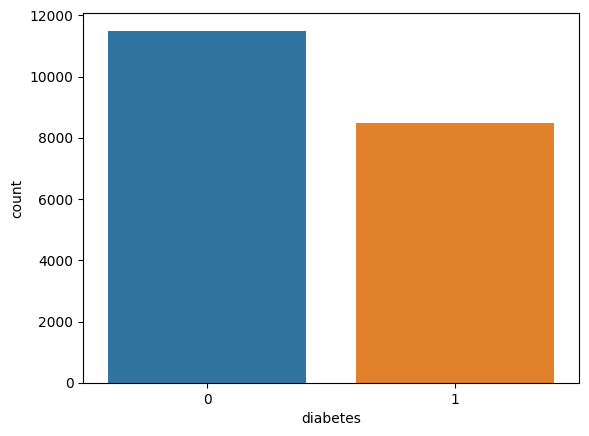

In [ ]:
num_not_diabetes, num_diabetes = data.diabetes.value_counts()
print("Number diabetes: ", num_diabetes)
print("Number not diabetes: ", num_not_diabetes)
sns.countplot(x ='diabetes', data = data)

**Gender analysis**

Text(0, 0.5, 'Count')

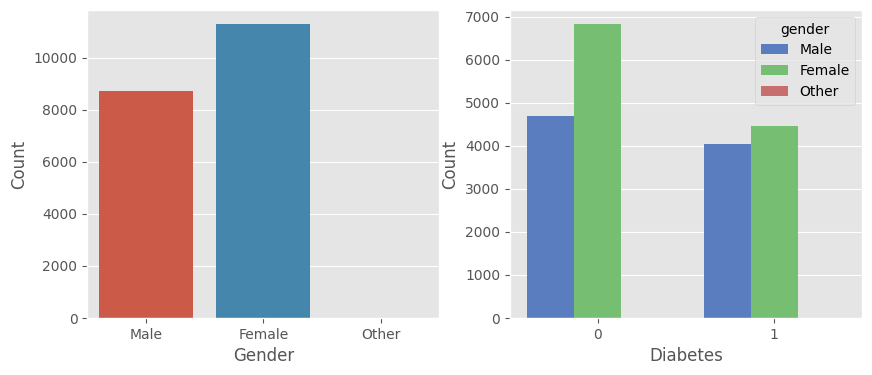

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x = 'gender', data = data, ax = axes[0])
plt.style.use('seaborn-v0_8-muted')
sns.countplot(data=data, x="diabetes", hue="gender", ax = axes[1])
axes[0].set_xlabel('Gender', fontsize = 12)
axes[0].set_ylabel('Count', fontsize = 12)

axes[1].set_xlabel('Diabetes', fontsize = 12)
axes[1].set_ylabel('Count', fontsize = 12)

In [ ]:
male_gender = data[data.gender == 'Male']
female_gender = data[data.gender == 'Female']

male_diabetes = male_gender[data.diabetes == 1]
female_diabetes = female_gender[data.diabetes == 1]

In [ ]:
female_diabetes.shape[0]

4461

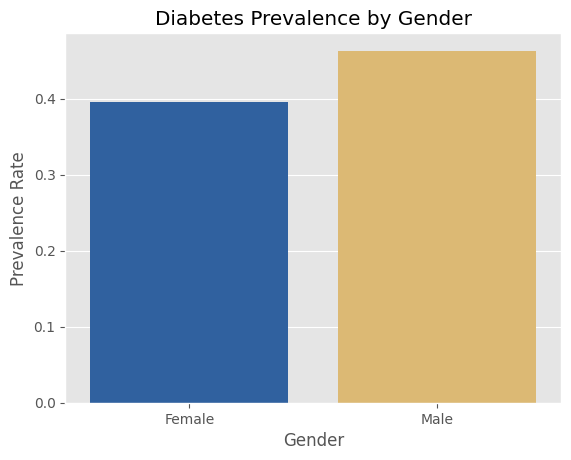

In [ ]:
prevalence_rate_females = female_diabetes.shape[0] / female_gender.shape[0]
prevalence_rate_males = male_diabetes.shape[0] / male_gender.shape[0]

# Create a dataframe for the data
df_prevalence = {'Gender': ['Female', 'Male'],
        'Prevalence Rate': [prevalence_rate_females, prevalence_rate_males]}
df_prevalence = pd.DataFrame(df_prevalence)

# Plot the bar plot
sns.barplot(x='Gender', y='Prevalence Rate', data=df_prevalence, palette = ["#1d5fb2", "#eebe62"])

# Set the plot labels
plt.title('Diabetes Prevalence by Gender')
plt.xlabel('Gender')
plt.ylabel('Prevalence Rate')

# Show the plot
plt.show()

Look at two plot, we can see that:

1. Number of female higher than male

2. Because of that, percentage female get diabetes higher than male (a little bit)

==> **Gender not a good feature to classfication diabetes**

**Age analysis**

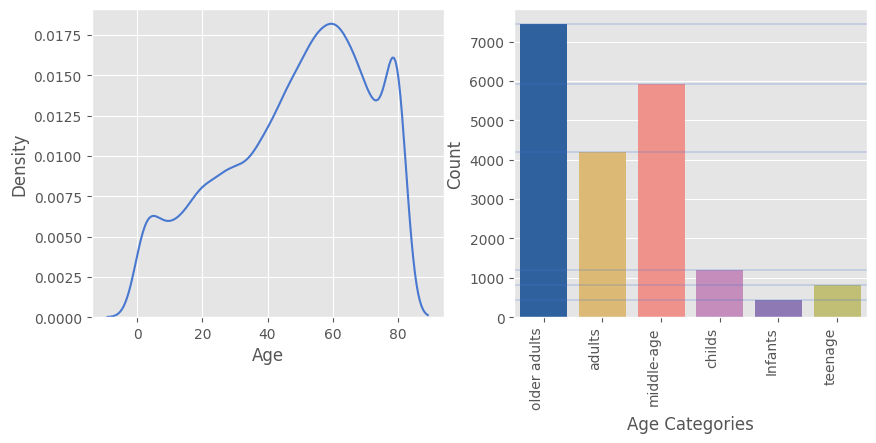

In [ ]:
def change_age(age) :
    if age <=2    :
        return "Infants"
    elif age>2 and age <=12 :
        return "childs"
    elif age >12 and age<=18 :
        return "teenage"
    elif age>18 and age<=40 :
        return "adults"
    elif age>40 and age<60 :
        return "middle-age"
    else :
        return "older adults"


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(data=data, x="age", ax = axes[0])
axes[0].set_xlabel('Age', fontsize = 12)
axes[0].set_ylabel('Density', fontsize = 12)


colors_chart = ["#1d5fb2", "#eebe62","#ff837c","#cd84c3", "#8b6fbf", "#ceca69" ]
data_modify['age range'] = data_modify['age'].apply(change_age)
sns.countplot(data=data_modify,x='age range',palette = colors_chart,ax = axes[1])
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='right')

axes[1].set_xlabel('Age Categories', fontsize = 12)
axes[1].set_ylabel('Count', fontsize = 12)

for i,index in zip(data_modify['age range'].value_counts().values, range(6)) :
    axes[1].axhline(y=i,linewidth=0.3)



Text(0.5, 1.0, 'Prevalence each age category of Diabete patients')

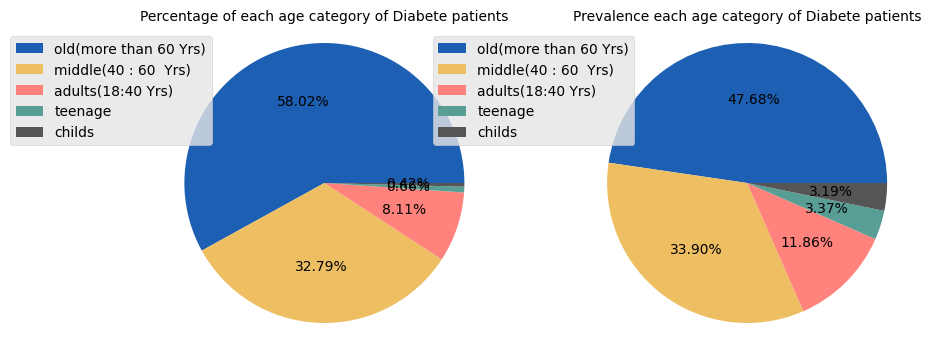

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#age vs target
color_pie = ["#1d5fb2", "#eebe62","#ff837c","#599e94", "#555555", 'black']


diabetic = data_modify[data_modify['diabetes']==1]
sizes = diabetic['age range'].value_counts().values
labels = diabetic['age range'].value_counts().index


axes[0].pie(x=sizes,
        colors = color_pie,
        explode=(0,0,0,0,0),
       autopct='%1.2f%%')
axes[0].legend(labels, loc='lower right', bbox_to_anchor=(.2,0.6))
axes[0].axis('equal')
axes[0].set_title("Percentage of each age category of Diabete patients", fontsize = 10)

#age vs target
color_pie = ["#1d5fb2", "#eebe62","#ff837c","#599e94", "#555555"]

diabetic = data_modify[data_modify['diabetes']==1]
sizes = diabetic['age range'].value_counts().values
labels = diabetic['age range'].value_counts().index

diabetes_prevalence_age = sizes / data_modify['age range'].value_counts().values[:len(labels)]

axes[1].pie(x=diabetes_prevalence_age,
        colors = color_pie,
        explode=(0,0,0,0,0),
       autopct='%1.2f%%')
axes[1].legend(labels, loc='lower right', bbox_to_anchor=(.2,0.6))
axes[1].axis('equal')
axes[1].set_title("Prevalence each age category of Diabete patients", fontsize = 10)

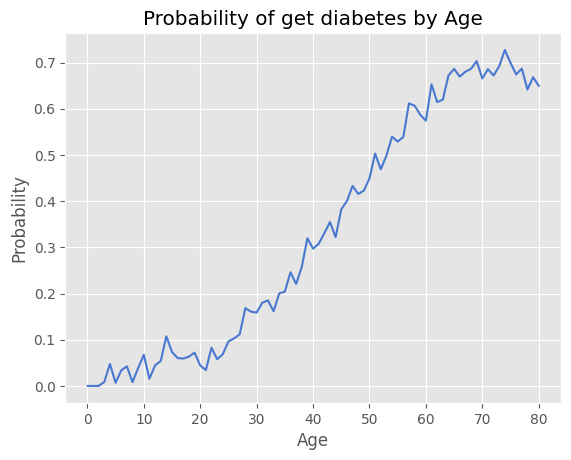

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate probability of diabetes at each age
age_probability = data.groupby('age')['diabetes'].mean()

# Create the line plot
plt.plot(age_probability.index, age_probability.values, linestyle='-')

# Set plot labels and title
plt.xlabel('Age')
plt.ylabel('Probability')
plt.title('Probability of get diabetes by Age')

# Show the plot
plt.show()


Look at four plot, we can see that:
+ Diabetes focus on middle age (40 - 60 years old) and old age (60 > years old)
+ Teenage, Infants hard to get diabetes
+ Childs can get diabetes but not much

--> *The more older people are, the easier they get diabetes*

 **=> Age is rick factor for classification diabetes**

**Body Mass Index analysis**

According research, bmi are splitting to 4 types

1.   **Underweight range**: bmi < 18.5
2.   **Healthy weight range**: bmi in range [18.5;25)
3.   **Overweight range**: bmi in range [25, 30)
4.   **Obesity range**: bmi >= 30

Overweight        8699
Obesity           6647
Healthy weight    3485
Underweight       1169
Name: bmi type, dtype: int64


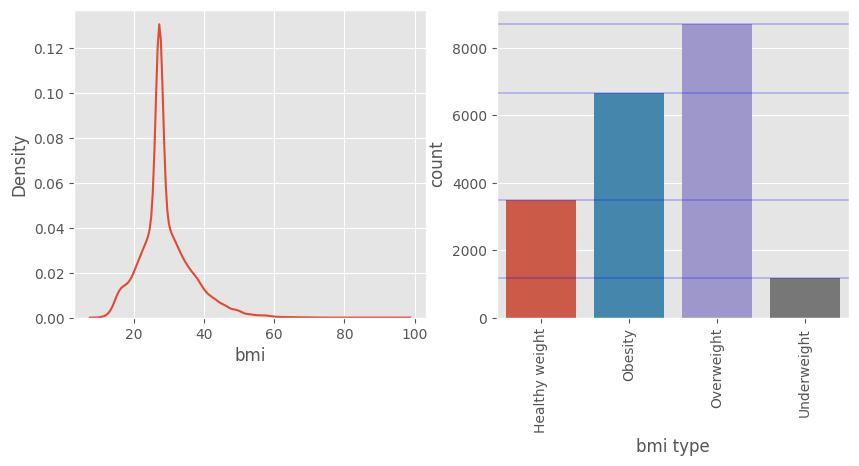

In [ ]:
def change_bmi(bmi) :
    if bmi < 18.5:
      return "Underweight"
    elif 18.5 <= bmi < 25:
      return "Healthy weight"
    elif 25 <= bmi < 30:
      return "Overweight"
    else:
      return "Obesity"

plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(data=data_modify, x="bmi", ax = axes[0])

data_modify['bmi type'] = data['bmi'].apply(change_bmi)
fig = sns.countplot(data=data_modify,x='bmi type', ax = axes[1])
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')
for i in data_modify['bmi type'].value_counts().values :
    plt.axhline(y=i,color='b',linewidth=0.3)

print(data_modify['bmi type'].value_counts())

Text(0.5, 1.0, 'Prevalence each bmi category of Diabete patients')

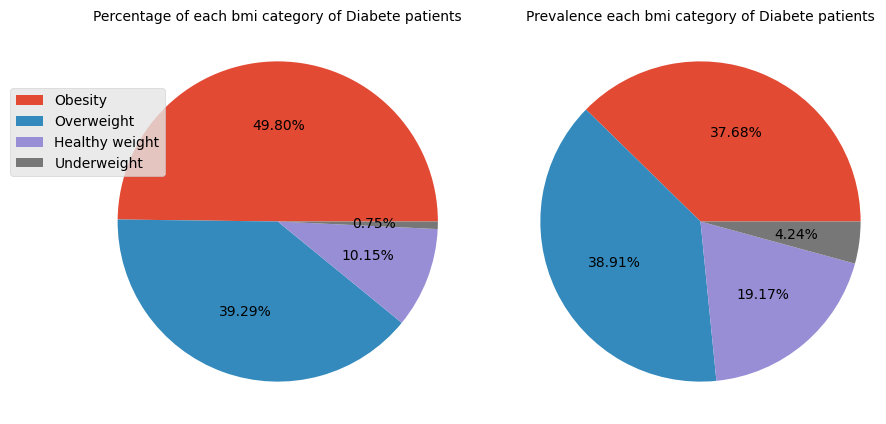

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#age vs target
color_pie = ["#1d5fb2", "#eebe62","#ff837c","#599e94", "#555555", 'black']


diabetic = data_modify[data_modify['diabetes']==1]
sizes = diabetic['bmi type'].value_counts().values
labels = diabetic['bmi type'].value_counts().index


axes[0].pie(x=sizes,
        explode=(0,0,0,0),
       autopct='%1.2f%%')
axes[0].legend(labels, loc='lower right', bbox_to_anchor=(.2,0.6))
axes[0].axis('equal')
axes[0].set_title("Percentage of each bmi category of Diabete patients", fontsize = 10)

#age vs target
color_pie = ["#1d5fb2", "#eebe62","#ff837c","#599e94", "#555555"]

diabetes_prevalence_bmi = sizes / data_modify['bmi type'].value_counts().values[:len(labels)]

axes[1].pie(x=diabetes_prevalence_bmi,
        explode=(0,0,0,0),
       autopct='%1.2f%%')
axes[1].axis('equal')
axes[1].set_title("Prevalence each bmi category of Diabete patients", fontsize = 10)

Looking at three plot, we can see that:



1.   Patients have Overweight and Obesity weight typ easier to get diabetes

2.   Patiens have Underweight very hard to get diabetes

==> *If a people have a high bmi (bmi >= 25), they have high percentage get diabetes, people have a small bmi (bmi < 18.5) hard to get diabetes*

==> **BMI is a rick factor to classfication diabetes**



**Smoking history analysis**

<Axes: xlabel='smoking_history', ylabel='count'>

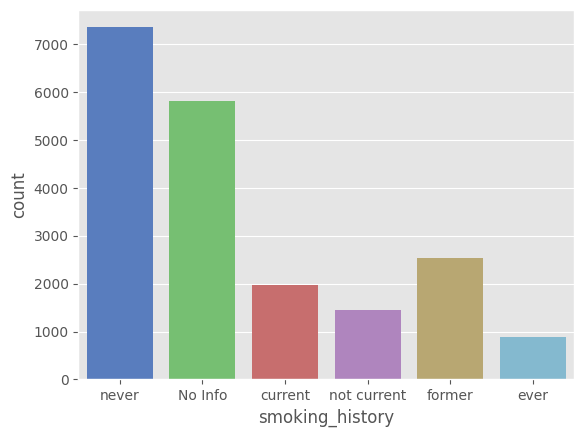

In [ ]:
plt.style.use('seaborn-v0_8-muted')
sns.countplot(x ='smoking_history', data = data)

<Axes: xlabel='smoking_history', ylabel='count'>

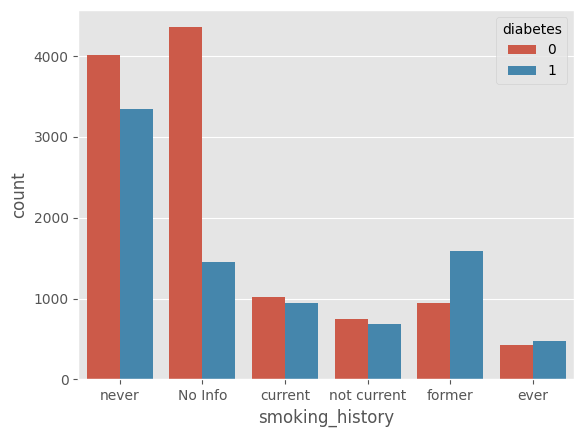

In [ ]:
plt.style.use('ggplot')
sns.countplot(data=data, x="smoking_history", hue="diabetes")

Text(0.5, 1.0, 'Percentage of each Smoking history of Diabetes patients')

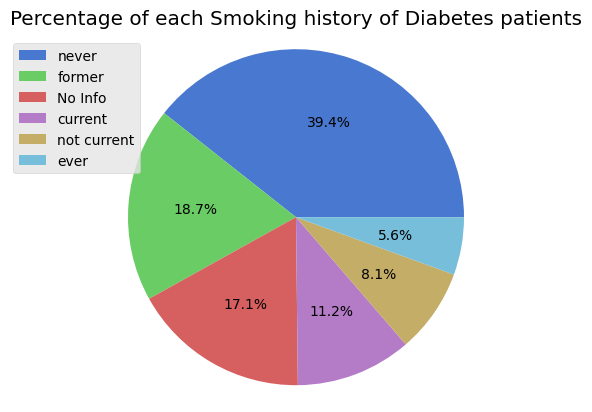

In [ ]:
#bmi vs target
plt.style.use('seaborn-v0_8-muted')
diabetic = data[data['diabetes']==1]
sizes = diabetic['smoking_history'].value_counts().values
labels = diabetic['smoking_history'].value_counts().index

plt.pie(x=sizes,
        explode=(0,0,0,0,0,0),
       autopct='%1.1f%%')
plt.legend(labels, loc='lower right', bbox_to_anchor=(.2,0.6))
plt.axis('equal')
plt.title("Percentage of each Smoking history of Diabetes patients")

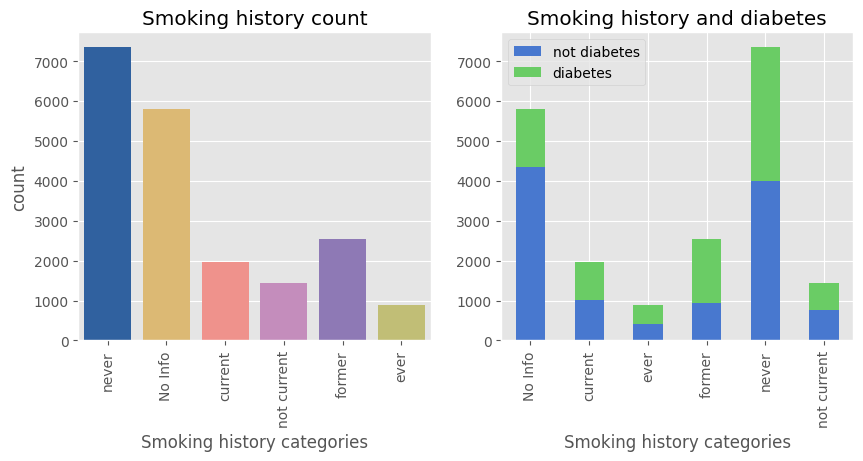

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,  4))

colors_chart = ["#1d5fb2", "#eebe62","#ff837c","#cd84c3", "#8b6fbf", "#ceca69" ]

# first
sns.countplot(x ='smoking_history', data = data, ax = axes[0], palette = colors_chart)

# second
cross_tab = pd.crosstab(data['smoking_history'], data['diabetes'])

plt.style.use(style="seaborn-v0_8-muted")
cross_tab.plot(kind="bar", stacked=True, ax = axes[1])

plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')

axes[0].set_xlabel('Smoking history categories')
axes[0].set_title('Smoking history count')

axes[1].set_xlabel('Smoking history categories')
axes[1].set_title('Smoking history and diabetes')
axes[1].legend(['not diabetes','diabetes'])


plt.show()

Text(0.5, 1.0, 'Prevalence each smoking history of Diabete patients')

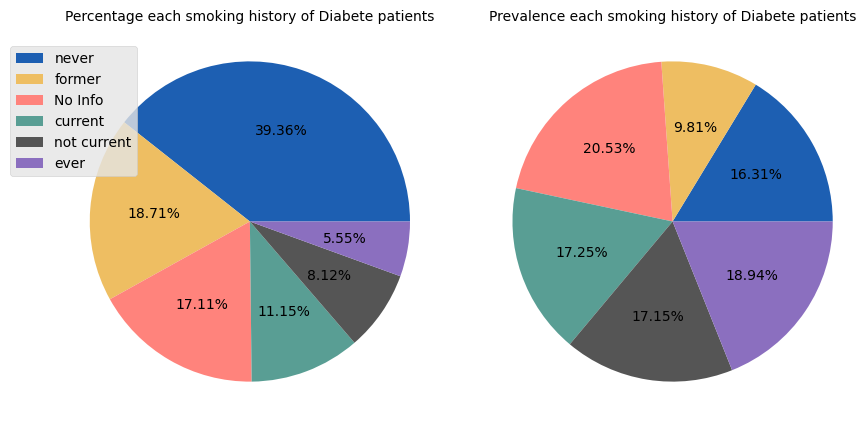

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#age vs target
color_pie = ["#1d5fb2", "#eebe62","#ff837c","#599e94", "#555555", '#8b6fbf']

diabetic = data[data['diabetes']==1]
sizes = diabetic['smoking_history'].value_counts().values
labels = diabetic['smoking_history'].value_counts().index


axes[0].pie(x=sizes,
        colors = color_pie,
        explode=(0,0,0,0,0,0),
       autopct='%1.2f%%')
axes[0].legend(labels, loc='lower right', bbox_to_anchor=(.2,0.6))
axes[0].axis('equal')
axes[0].set_title("Percentage each smoking history of Diabete patients", fontsize = 10)

diabetes_prevalence_smoke = sizes / data['smoking_history'].value_counts().values[:len(labels)]

axes[1].pie(x=diabetes_prevalence_smoke,
        colors = color_pie,
        explode=(0,0,0,0,0,0),
       autopct='%1.2f%%')

axes[1].axis('equal')
axes[1].set_title("Prevalence each smoking history of Diabete patients", fontsize = 10)

After seeing three plot, we can see that:

1.  Although dataset don't have balanced target, each smoking history in diabetes and not diabetes not too disinct

2.  No-info data have high percentage in smoking history, and that make classification seems missy.

==> **Smoking history not a good feature to classification diabetes**

**Analysis hypertension**

<Axes: xlabel='hypertension', ylabel='count'>

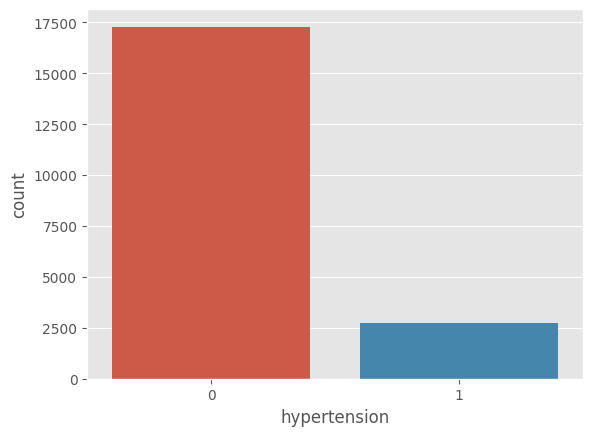

In [ ]:
sns.countplot(x ='hypertension', data = data)

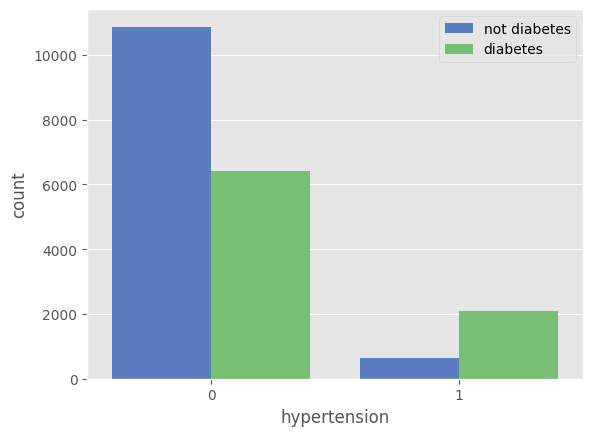

In [ ]:
plt.style.use('seaborn-v0_8-muted')
sns.countplot(x ='hypertension', data = data, hue = 'diabetes')
plt.legend(['not diabetes','diabetes'])

In [ ]:
data.hypertension.value_counts()

0    17286
1     2714
Name: hypertension, dtype: int64

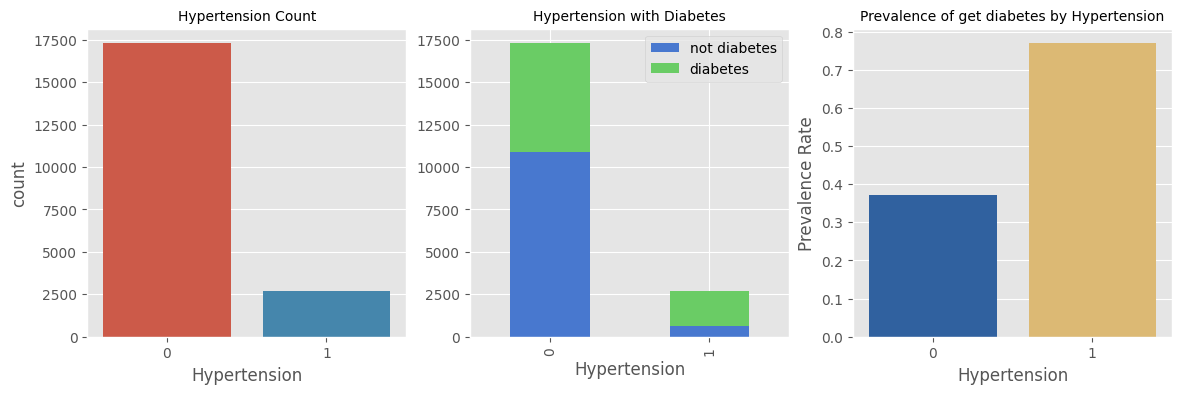

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plt.style.use('ggplot')
sns.countplot(x ='hypertension', data = data, ax = axes[0])

plt.style.use('seaborn-v0_8-muted')

# Create a cross-tabulation of heart_disease and diabetes
cross_tab = pd.crosstab(data['hypertension'], data['diabetes'])
cross_tab.plot(kind="bar", stacked=True, ax = axes[1])

axes[1].legend(['not diabetes','diabetes'])


prevalence = data[data.diabetes == 1].hypertension.value_counts() / data.hypertension.value_counts()

df_prevalence = {'Hypertension': ['0', '1'],
        'Prevalence Rate': prevalence}
df_prevalence = pd.DataFrame(df_prevalence)

# Plot the bar plot
sns.barplot(x='Hypertension', y='Prevalence Rate', data=df_prevalence, palette = ["#1d5fb2", "#eebe62"], ax = axes[2])

titles = ['Hypertension Count','Hypertension with Diabetes','Prevalence of get diabetes by Hypertension']

axes[1].set_ylabel('')

for i,ax in enumerate(axes):
  ax.set_xlabel('Hypertension')
  ax.set_title(titles[i], fontsize = 10)


Text(0.5, 1.0, 'Percentage of each Hypertension of Diabetes patients')

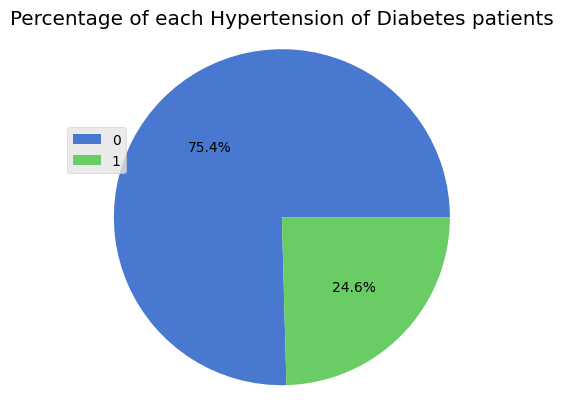

In [ ]:
#hypertension vs target
diabetic = data_modify[data_modify['diabetes']==1]
sizes = diabetic['hypertension'].value_counts().values
labels = diabetic['hypertension'].value_counts().index

plt.pie(x=sizes,
        explode=(0,0),
       autopct='%1.1f%%')
plt.legend(labels, loc='lower right', bbox_to_anchor=(.2,0.6))
plt.axis('equal')
plt.title("Percentage of each Hypertension of Diabetes patients")

Look at three plot, we can see that:

1.  Hypertension have high percentage in "0" label.

2.  In plot 2, we can see that hypertension "1" get diabetes larger than hypertension "0" although number of "0" very much.

3. But in plot 3, in overral number of hypertension "0" too much so percentage in get diabetes high too.

==> **I think hypertension not a good feature to classifcation diabetes, they only good in classfication when hypertension is "1" (but number of "1" is not much)**

**Heart disease**

Text(0.5, 1.0, 'Percentage of each Heart disease of Diabetes patients')

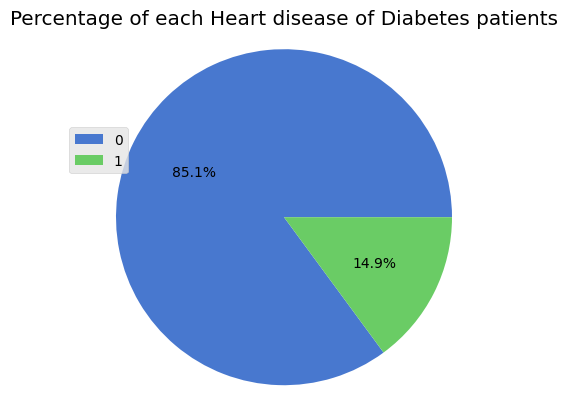

In [ ]:
#bmi vs target
diabetic = data_modify[data_modify['diabetes']==1]
sizes = diabetic['heart_disease'].value_counts().values
labels = diabetic['heart_disease'].value_counts().index

plt.pie(x=sizes,
        explode=(0,0),
       autopct='%1.1f%%')
plt.legend(labels, loc='lower right', bbox_to_anchor=(.2,0.6))
plt.axis('equal')
plt.title("Percentage of each Heart disease of Diabetes patients")

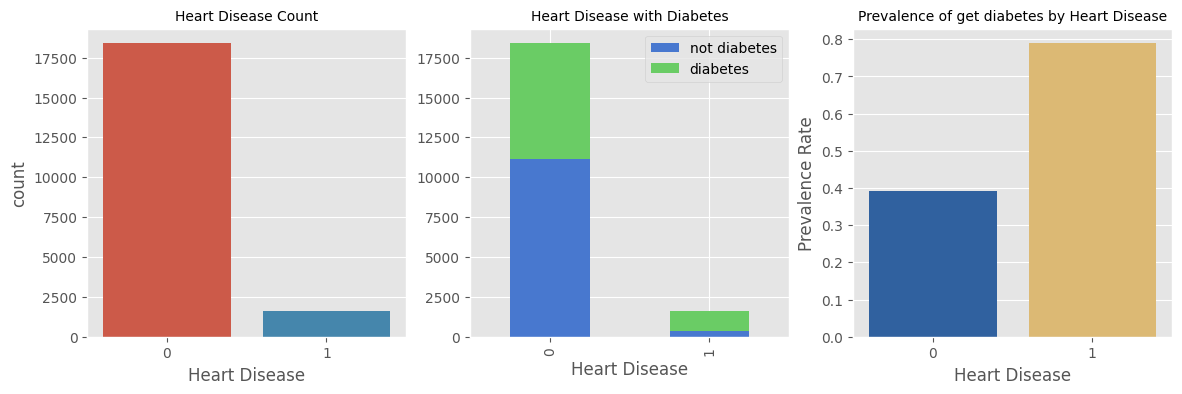

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plt.style.use('ggplot')
sns.countplot(x ='heart_disease', data = data, ax = axes[0])

plt.style.use('seaborn-v0_8-muted')

# Create a cross-tabulation of heart_disease and diabetes
cross_tab = pd.crosstab(data['heart_disease'], data['diabetes'])
cross_tab.plot(kind="bar", stacked=True, ax = axes[1])

axes[1].legend(['not diabetes','diabetes'])


prevalence = data[data.diabetes == 1].heart_disease.value_counts() / data.heart_disease.value_counts()

df_prevalence = {'Heart Disease': ['0', '1'],
        'Prevalence Rate': prevalence}
df_prevalence = pd.DataFrame(df_prevalence)

# Plot the bar plot
sns.barplot(x='Heart Disease', y='Prevalence Rate', data=df_prevalence, palette = ["#1d5fb2", "#eebe62"], ax = axes[2])

titles = ['Heart Disease Count','Heart Disease with Diabetes','Prevalence of get diabetes by Heart Disease']

axes[1].set_ylabel('')

for i,ax in enumerate(axes):
  ax.set_xlabel('Heart Disease')
  ax.set_title(titles[i], fontsize = 10)


In [ ]:
data.heart_disease.value_counts()

0    18394
1     1606
Name: heart_disease, dtype: int64

From 3 plot, we can see that:

1.  Like hypertension, heart diasease not balanced about label 0 and 1. Label 0 has too much in total

2.  Because not balanced, in plot 2, in both label, number of get diabetes just have a few of them. In plot 3 seem too

==> **Heart diasease don't help anything about classfication diabetes**

**HbA1c Level and Blood glucose level analysis**

<Axes: xlabel='blood_glucose_level', ylabel='Density'>

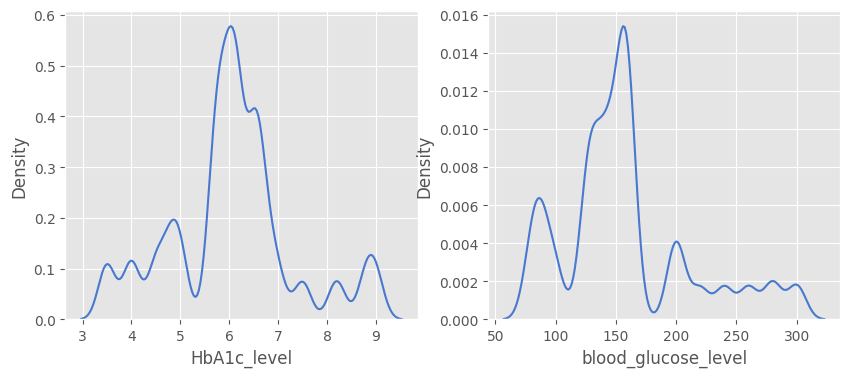

In [ ]:
sns.color_palette("crest", as_cmap=True)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
sns.kdeplot(data=data, x="HbA1c_level", ax = axes[0], palette = 'crest')
sns.kdeplot(data=data, x="blood_glucose_level", ax = axes[1], palette = 'crest')


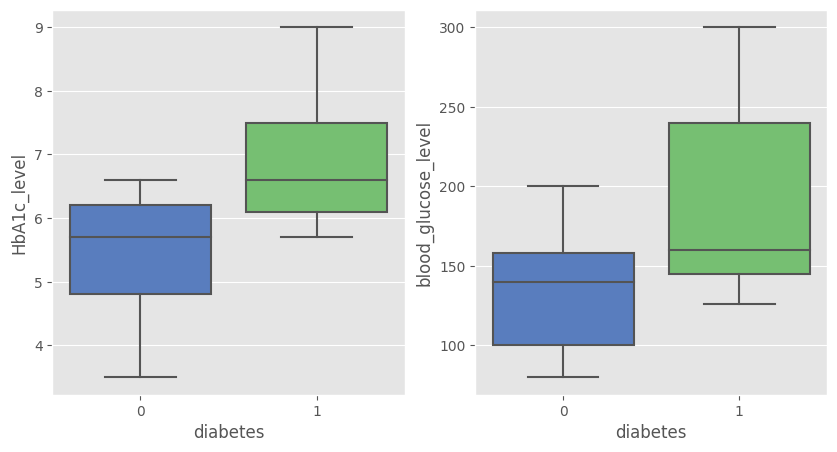

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
sns.boxplot(ax = axes[0],x = "diabetes", y = "HbA1c_level", data = data)
sns.boxplot(ax = axes[1],x = "diabetes", y = "blood_glucose_level",data = data)
plt.show()

<Axes: xlabel='HbA1c_level', ylabel='diabetes'>

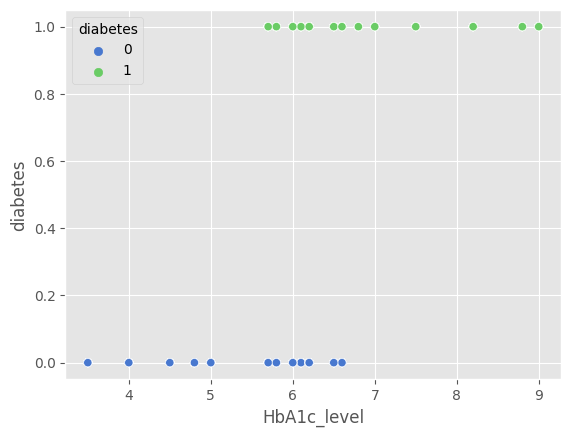

In [ ]:
sns.scatterplot(data=data, x="HbA1c_level", y="diabetes", hue = 'diabetes')

[]

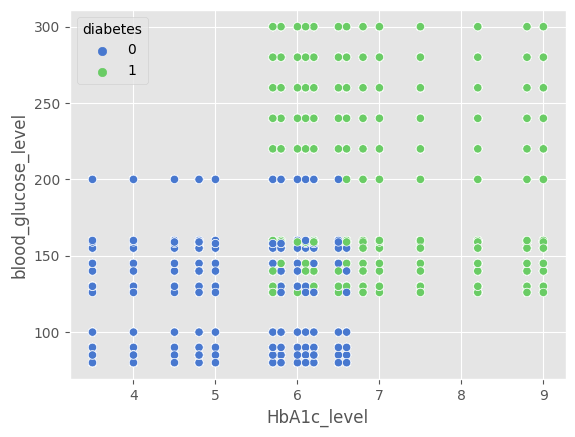

In [ ]:
sns.scatterplot(x = "HbA1c_level", y = "blood_glucose_level", hue = "diabetes", data = data)
plt.plot()

**Conclusion**

After analysis, we have:

+ Good Feature: Age, BMI, HbA1c level, Blood glucose level

+ Bad Feature: Gender, hypertension, Heart diasease, smooking history

To ensure, we will plot correlation between each feature and target

**Correlation between good feature and target**

<Axes: >

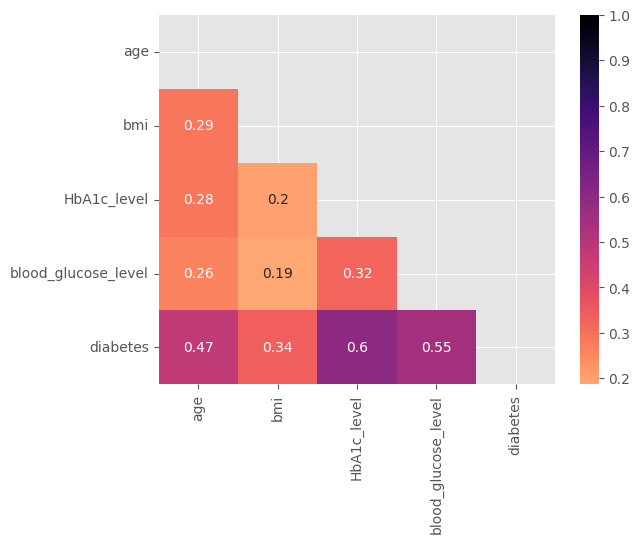

In [ ]:
good_features = ['age','bmi','HbA1c_level','blood_glucose_level','diabetes']
heat = data[good_features].corr()
mask  = np.triu(heat)
sns.heatmap(data=heat,mask=mask,cmap='magma_r',vmax=1,center=0.5,annot=True)

**Correlation between bad feature and target**

In [ ]:
data_modify['gender'] = LabelEncoder().fit_transform(data_modify['gender'])
data_modify['smoking_history'] = LabelEncoder().fit_transform(data_modify['smoking_history'])

<Axes: >

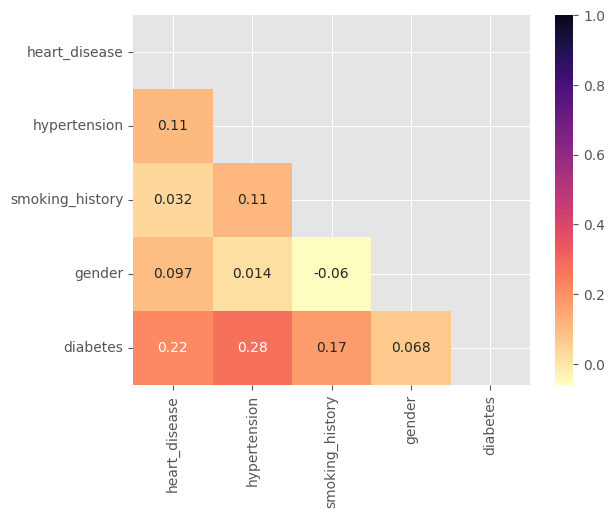

In [ ]:
bad_features = ['heart_disease','hypertension','smoking_history','gender','diabetes']
heat = data_modify[bad_features].corr()
mask  = np.triu(heat)
sns.heatmap(data=heat,mask=mask,cmap='magma_r',vmax=1,center=0.5,annot=True)

# Preprocessing Data

In [ ]:
data_modify = data.copy()

**Encoded Label**

In [ ]:
le = LabelEncoder()
data_modify.gender = le.fit_transform(data_modify.gender)
data_modify.smoking_history = le.fit_transform(data_modify.smoking_history)

**Train test split**

In [ ]:
X = data_modify.drop('diabetes', axis = 1)
y = data_modify.diabetes

In [ ]:
X_good_feature = data.drop(["diabetes","smoking_history","gender","heart_disease","hypertension"],axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
X_train_gf, X_test_gf, y_train_gf, y_test_gf = train_test_split(X_good_feature, y)

**Normalize data**

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [ ]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Training

In [ ]:
def evaluation(y_true,y_pred):
  cr = classification_report(y_true, y_pred)
  print("Classification Report")
  print(cr)
  cfm = confusion_matrix(y_true,y_pred)
  plt.figure(figsize=(8,6), dpi=100)
  # Scale up the size of all text

  ax = sns.heatmap(cfm, annot=True, fmt='d', )

  # set x-axis label and ticks.
  ax.set_xlabel("Predicted Diabetes", fontsize=14, labelpad=20)
  ax.xaxis.set_ticklabels(['Not diabetes', 'Diabetes'])

  # set y-axis label and ticks
  ax.set_ylabel("Actual Diabetes", fontsize=14, labelpad=20)
  ax.yaxis.set_ticklabels(['Not diabetes', 'Diabetes'])

  # set plot title
  ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

  plt.show()

# Apply Model

##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression().fit(X_train,y_train)
y_pred = lgr.predict(X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2857
           1       0.87      0.85      0.86      2143

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



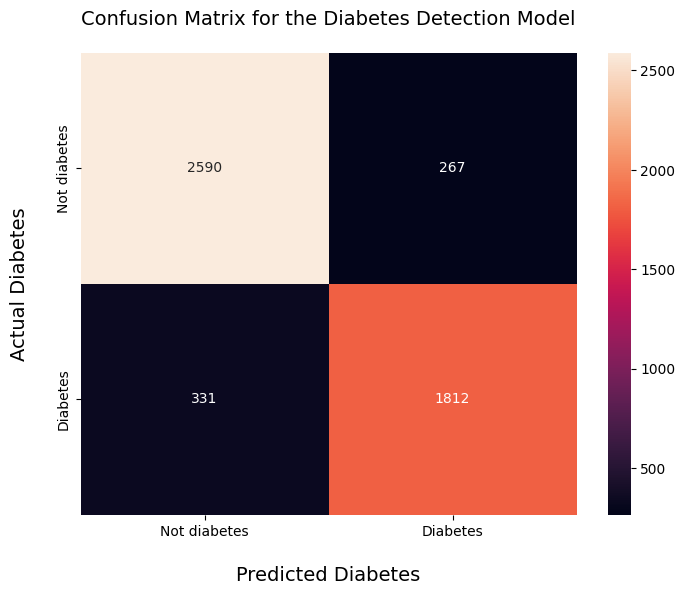

In [ ]:
evaluation(y_test,y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.8804

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
grid={"C":[0.01,0.1,1,10,100,1000], "penalty":['l1','l2'],"solver":[ 'liblinear', 'saga','lbfgs']}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=20)
logreg_cv.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

GridSearchCV(cv=20, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga', 'lbfgs']})

In [ ]:
logreg_df=pd.DataFrame(data=logreg_cv.cv_results_)

In [ ]:
logreg_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'split10_test_score', 'split11_test_score',
       'split12_test_score', 'split13_test_score', 'split14_test_score',
       'split15_test_score', 'split16_test_score', 'split17_test_score',
       'split18_test_score', 'split19_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
logreg_df=logreg_df.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'split10_test_score', 'split11_test_score',
       'split12_test_score', 'split13_test_score', 'split14_test_score',
       'split15_test_score', 'split16_test_score', 'split17_test_score',
       'split18_test_score', 'split19_test_score', ],axis = 1)

In [ ]:
logreg_df=logreg_df.dropna()

In [ ]:
logreg_df = logreg_df.sort_values(by=['rank_test_score'])

In [ ]:
logreg_df.head(10)

,param_C,param_penalty,param_solver,mean_test_score,std_test_score,rank_test_score
15,1,l2,liblinear,0.884733,0.012063,1
17,1,l2,lbfgs,0.884467,0.012032,2
6,0.1,l1,liblinear,0.884400,0.012148,3
7,0.1,l1,saga,0.884400,0.011731,3
16,1,l2,saga,0.884400,0.011978,5
33,1000,l2,liblinear,0.884267,0.012786,6
31,1000,l1,saga,0.884267,0.012786,6
30,1000,l1,liblinear,0.884267,0.012786,6
29,100,l2,lbfgs,0.884267,0.012786,6
28,100,l2,saga,0.884267,0.012786,6


In [ ]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8847333333333334


In [ ]:
lgr = LogisticRegression(C =1, penalty = 'l2', solver = "liblinear").fit(X_train,y_train)
y_pred = lgr.predict(X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2857
           1       0.87      0.85      0.86      2143

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



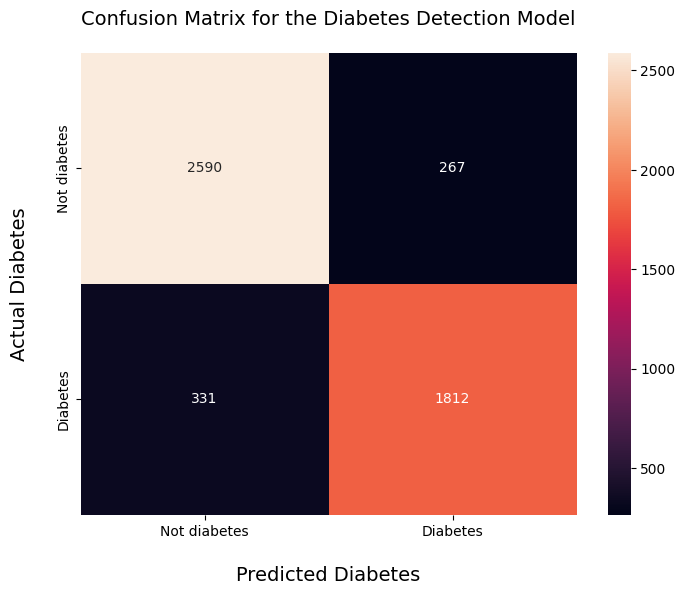

In [ ]:
evaluation(y_test,y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.8804

##SVM

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2892
           1       0.87      0.85      0.86      2108

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



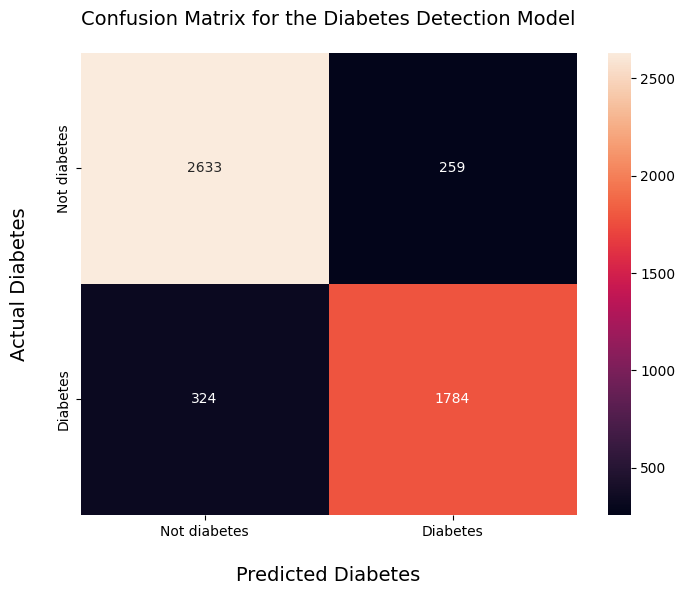

In [ ]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)

evaluation(y_test,y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.8894

Tuning

In [ ]:
C_range = np.logspace(2, 4, 10)
gamma_range = np.logspace(-1, -10, 10)
param = { "C": C_range,
          "kernel": ['rbf', 'poly', 'sigmoid'],
          "gamma": gamma_range.tolist() + ['auto', 'scale']
        }

# Define random search
svm_model_cv = SVC()
svm_gs = GridSearchCV(estimator=svm_model_cv,
                      param_grid = param,
                      cv=2)
# Fit grid search
svm_gs_result = svm_gs.fit(X_train, y_train)


In [ ]:
print("Kết quả tuning:")
print("Best params:", svm_gs_result.best_params_)
print("Best score:", svm_gs_result.best_score_)

Kết quả tuning:
Best params: {'C': 278.2559402207126, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9014666666666666


best 10 hyperparameter

In [ ]:
svm_gs_result_df=pd.DataFrame(svm_gs_result.cv_results_)
svm_gs_result_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [ ]:
svm_gs_result_df=svm_gs_result_df.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params',
       'split0_test_score', 'split1_test_score'],axis = 1)

In [ ]:
svm_gs_result_df = svm_gs_result_df.dropna()

In [ ]:
svm_gs_result_df = svm_gs_result_df.sort_values(by=['rank_test_score'])

In [ ]:
svm_gs_result_df.head(10)

,param_C,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
105,278.25594,scale,rbf,0.901467,0.000267,1
33,100.0,scale,rbf,0.901400,0.000067,2
177,774.263683,scale,rbf,0.901267,0.000600,3
141,464.158883,scale,rbf,0.901133,0.001133,4
213,1291.549665,scale,rbf,0.901067,0.000667,5
69,166.810054,scale,rbf,0.901000,0.000333,6
34,100.0,scale,poly,0.899867,0.002133,7
286,3593.813664,scale,poly,0.899600,0.001600,8
250,2154.43469,scale,poly,0.899600,0.001600,8
354,10000.0,auto,rbf,0.899533,0.001667,10


Training với best hyperparameter

Best Model Accuracy: 0.8942
Best Hyperparameters: {'C': 278.2559402207126, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2892
           1       0.88      0.87      0.87      2108

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



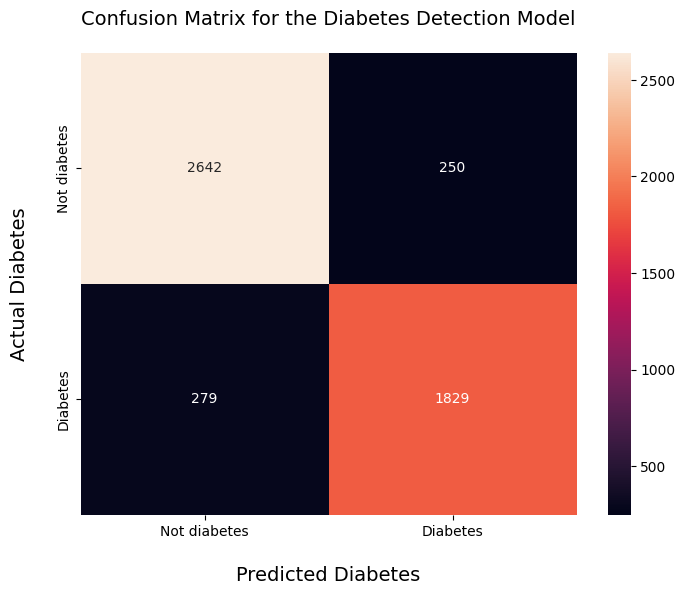

In [ ]:
best_params = svm_gs_result.best_params_
best_model = svm_gs_result.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model Accuracy:", accuracy)

evaluation(y_test,y_pred)

##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn import tree
dtc = DecisionTreeClassifier()

###**Without tunning model**

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2859
           1       0.86      0.85      0.86      2141

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



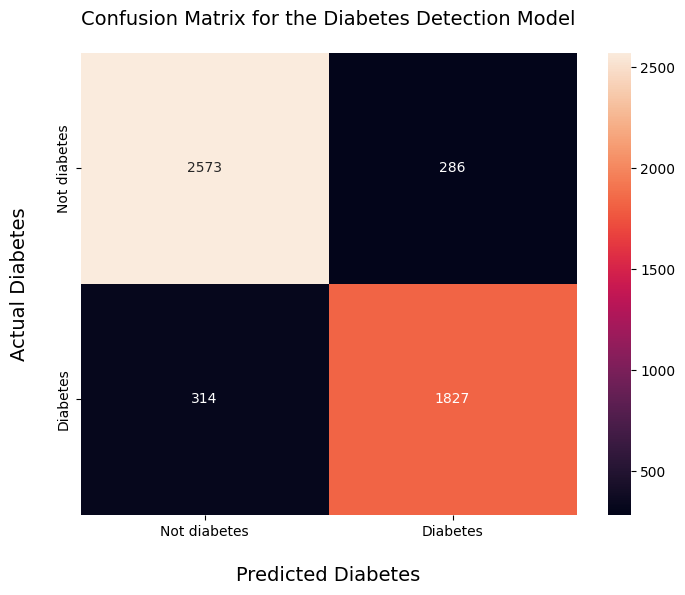

In [ ]:
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
evaluation(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.876

###**With tunning model**

In [ ]:
params = { "min_samples_split":[5,10,15,20,25],
          "min_samples_leaf":[10,11,12,15,20],
          "max_depth":[9,10,11,12,15,20],
           "criterion": ['gini','entropy']
        }
dtc_cv=GridSearchCV(dtc,params,cv=20)
dtc_cv.fit(X_train,y_train)
dtc_df=pd.DataFrame(data=dtc_cv.cv_results_)
dtc_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
dtc_df = dtc_df.loc[:,["param_criterion","param_max_depth","param_min_samples_leaf","param_min_samples_split","mean_test_score","rank_test_score"]]
dtc_df

,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score,rank_test_score
0,gini,9,10,5,0.899933,102
1,gini,9,10,10,0.900000,96
2,gini,9,10,15,0.899933,102
3,gini,9,10,20,0.899933,102
4,gini,9,10,25,0.899800,112
...,...,...,...,...,...,...
295,entropy,20,20,5,0.895600,235
296,entropy,20,20,10,0.895533,242
297,entropy,20,20,15,0.895667,229
298,entropy,20,20,20,0.895600,235


In [ ]:
dtc_df_sorted = dtc_df.sort_values(by=['rank_test_score'])
dtc_df_sorted.head(10)

,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score,rank_test_score
202,entropy,11,10,15,0.902800,1
206,entropy,11,11,10,0.902600,2
200,entropy,11,10,5,0.902600,2
210,entropy,11,12,5,0.902600,2
204,entropy,11,10,25,0.902533,5
203,entropy,11,10,20,0.902533,6
205,entropy,11,11,5,0.902533,6
207,entropy,11,11,15,0.902533,6
201,entropy,11,10,10,0.902533,6
211,entropy,11,12,10,0.902467,10


**Applying best hyperparameters for model**

In [ ]:
best_params = dtc_cv.best_params_
best_model = dtc_cv.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
print("Best Hyperparameters:", best_params)

Best Model Accuracy: 0.9014
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 15}


Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2859
           1       0.90      0.87      0.88      2141

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



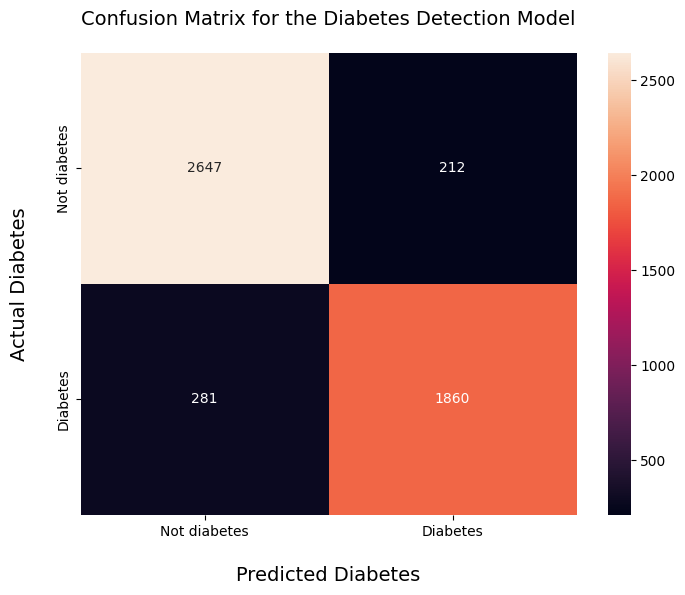

In [ ]:
evaluation(y_test,y_pred)

## Random Forest

### **Without tuning model**



---
**Traning model with dataset are split by train_test_split**


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2857
           1       0.89      0.89      0.89      2143

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



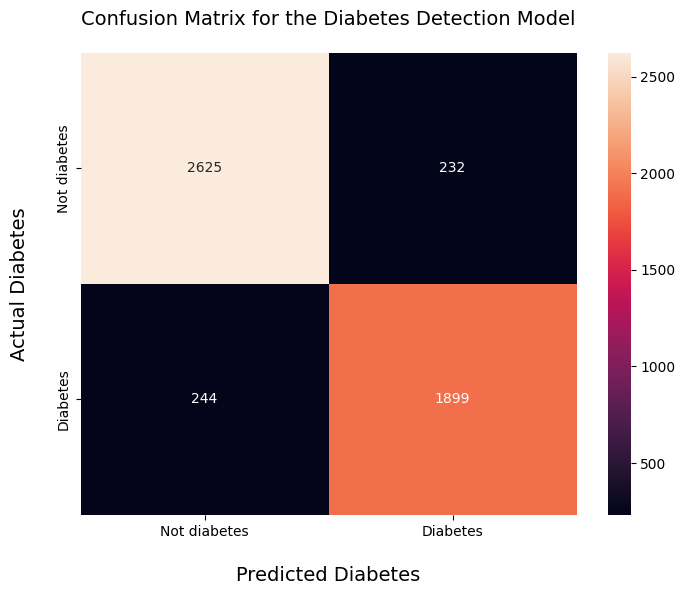

In [ ]:
evaluation(y_test,y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.902

In [ ]:
feature_important = X.columns[np.argsort(-rfc.feature_importances_)]
feature_value = -np.sort(-rfc.feature_importances_)
pd.DataFrame({'feature': feature_important, 'feature importants': feature_value})

,feature,feature importants
0,HbA1c_level,0.346319
1,blood_glucose_level,0.273175
2,age,0.173508
3,bmi,0.123792
4,smoking_history,0.033763
5,hypertension,0.025897
6,heart_disease,0.015009
7,gender,0.008537


**Traning model with dataset are split by k-fold cross validation**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Initialize the KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True)

# Initialize a list to store the accuracies
accuracies = []

overall_cm = np.zeros((2, 2))

X_np = X.to_numpy();
# Perform cross-validation
for train_index, test_index in kfold.split(X_np):
    rf_kfold = RandomForestClassifier()
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the Random Forest classifier
    rf_kfold.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_kfold.predict(X_test)

    # Calculate the accuracy and store it in the accuracies list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    cm = confusion_matrix(y_test, y_pred)
    overall_cm += cm

# Calculate the average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print("Average Accuracy:", average_accuracy)

Average Accuracy: 0.9032


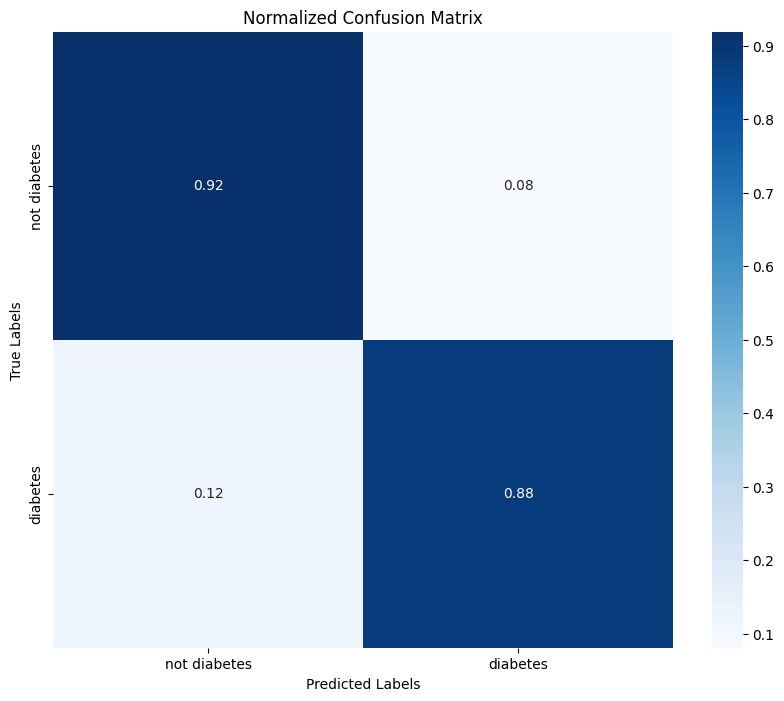

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the normalized confusion matrix
normalized_cm = overall_cm / overall_cm.sum(axis=1, keepdims=True)

# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt=".2f", xticklabels=['not diabetes','diabetes'], yticklabels=['not diabetes','diabetes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

### **Tuning model**

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'criterion': ['gini','entropy'],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['log2', 'sqrt'],
    'ccp_alpha': [0.0, 0.01, 0.015, 0.02]
}

# Initialize the Random Forest classifier
rf_grid = RandomForestClassifier()

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv=5)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.01, 0.015, 0.02],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [100, 200, 300]})

In [ ]:
import pickle

file_train = 'data_train'
file_test = 'data_test'
X_train,y_train = pickle.load(open(file_train, 'rb'))
X_test,y_test = pickle.load(open(file_test, 'rb'))


In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
print("Best Hyperparameters:", best_params)

Best Model Accuracy: 0.913
Best Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 200}


In [ ]:
rf_grid_result = pd.DataFrame(grid_search.cv_results_)

In [ ]:
rf_grid_result.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_ccp_alpha', 'param_criterion', 'param_max_depth',
       'param_max_features', 'param_min_samples_split', 'param_n_estimators',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
result = rf_grid_result.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score',
       'std_test_score'],axis = 1)

In [ ]:
result.sort_values(by=['rank_test_score']).head(10)

,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
166,0.0,entropy,15,sqrt,20,200,0.909933,1
155,0.0,entropy,15,log2,20,300,0.909733,2
58,0.0,gini,15,log2,20,200,0.909667,3
167,0.0,entropy,15,sqrt,20,300,0.909600,4
163,0.0,entropy,15,sqrt,10,200,0.909400,5
164,0.0,entropy,15,sqrt,10,300,0.909000,6
190,0.0,entropy,20,sqrt,20,200,0.908933,7
69,0.0,gini,15,sqrt,20,100,0.908933,7
186,0.0,entropy,20,sqrt,10,100,0.908867,9
71,0.0,gini,15,sqrt,20,300,0.908867,9


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2857
           1       0.90      0.90      0.90      2143

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



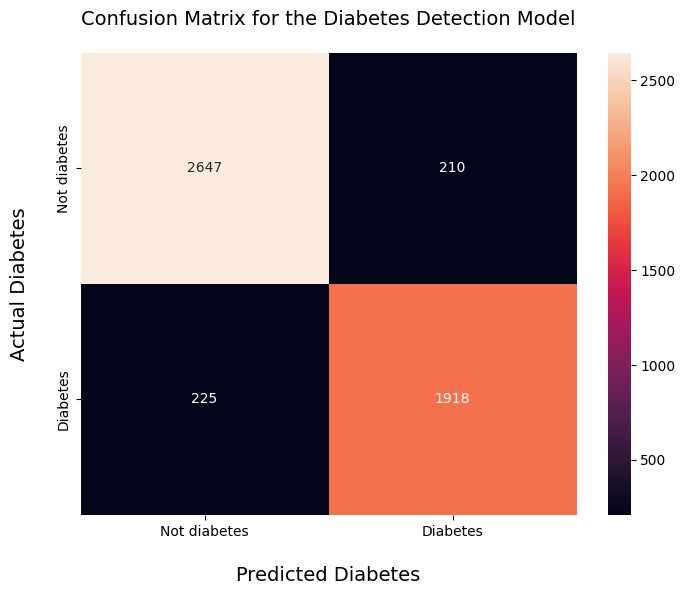

In [ ]:
evaluation(y_test,y_pred)